In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

In [3]:
# Input Data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/StdAnomERA5NH_500_z_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
t2m=t2mData.t2m.shift(time=1)
rh=rh_ds.rh.shift(time=1)
u10=u10Data.u10.shift(time=1)
v10=v10Data.v10.shift(time=1)
z=z500Data.z.shift(time=1)

In [18]:
t2mTs=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(60,0),longitude=slice(40,100))
rhTs=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(60,0),longitude=slice(40,100))
u10Ts=u10[((u10.time.dt.month>11) | (u10.time.dt.month<2)) & (u10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(60,0),longitude=slice(40,100))
v10Ts=u10[((v10.time.dt.month>11) | (v10.time.dt.month<2)) & (v10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(60,0),longitude=slice(40,100))
zTs=z[((z.time.dt.month>11) | (z.time.dt.month<2)) & (z.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(60,0),longitude=slice(40,100))

In [19]:
t1=t2mTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTs.values=t1.unstack()

t1=rhTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTs.values=t1.unstack()

t1=u10Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
u10Ts.values=t1.unstack()

t1=v10Ts.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
v10Ts.values=t1.unstack()

t1=zTs.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
zTs.values=t1.unstack()

In [20]:
z_train, z_test,t2m_train, t2m_test, rh_train, rh_test,v10_train, v10_test,u10_train, u10_test,y_train,y_test = train_test_split( zTs,t2mTs, rhTs,v10Ts,u10Ts,y,test_size=0.20, random_state=0)

In [21]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape
rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape

ztrain=z_train.values
ztrain=ztrain[:,:,:,None]
ztrain.shape

u10train=u10_train.values
u10train=u10train[:,:,:,None]
u10train.shape

v10train=v10_train.values
v10train=v10train[:,:,:,None]
v10train.shape

(1736, 31, 31, 1)

In [22]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape

(1736, 1)

In [23]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape
rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape
u10test=u10_test.values
u10test=u10test[:,:,:,None]
u10test.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape

v10test=v10_test.values
v10test=v10test[:,:,:,None]
v10test.shape

(434, 31, 31, 1)

In [24]:
#X_test=np.array([ztest,rhtest,u10test,v10test])
X_test=np.array([ztest,rhtest])
X_test.shape

#X_train=np.array([ztrain,rhtrain,u10train,v10train])
X_train=np.array([ztrain,rhtrain])
X_train.shape

(2, 1736, 31, 31, 1)

In [25]:
#nifti = np.random.randint(0,5,size=(508,512,513)) 
# set the last dim to 513 just to make stuff more clear
#nifti.shape
# (508, 512, 513)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


(434, 2, 31, 31, 1)

In [26]:
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

Epoch 1/10
55/55 [==============================] - 35s 627ms/step - loss: 0.4746 - val_loss: 0.1702
Epoch 2/10
55/55 [==============================] - 33s 609ms/step - loss: 0.1558 - val_loss: 0.1501
Epoch 3/10
55/55 [==============================] - 34s 613ms/step - loss: 0.1463 - val_loss: 0.1400
Epoch 4/10
55/55 [==============================] - 35s 628ms/step - loss: 0.1291 - val_loss: 0.1176
Epoch 5/10
55/55 [==============================] - 34s 613ms/step - loss: 0.1095 - val_loss: 0.1090
Epoch 6/10
55/55 [==============================] - 34s 613ms/step - loss: 0.0993 - val_loss: 0.1123
Epoch 7/10
55/55 [==============================] - 35s 634ms/step - loss: 0.0941 - val_loss: 0.1050
Epoch 8/10
55/55 [==============================] - 34s 615ms/step - loss: 0.0885 - val_loss: 0.1039
Epoch 9/10
55/55 [==============================] - 34s 620ms/step - loss: 0.0826 - val_loss: 0.1084
Epoch 10/10
55/55 [==============================] - 34s 612ms/step - loss: 0.0802 - val_lo

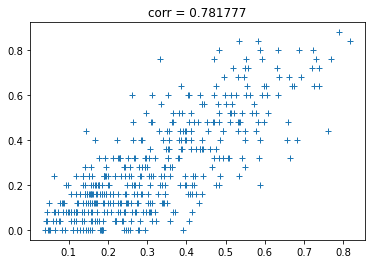

In [29]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)))
#model.add(MaxPooling3D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
model.add(MaxPooling3D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu',padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, activation='relu',padding='same'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')